##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Code Execution in the Gemini API

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Code_Execution.ipynb"><img src="https://github.com/google-gemini/cookbook/blob/ce76bbe63554b4fceeba6bf6c2ef4b264d3d2da9/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>


The Gemini API [code execution](https://ai.google.dev/gemini-api/docs/code-execution) feature enables the model to generate and run Python code based on plain-text instructions that you give it. It can learn iteratively from the results until it arrives at a final output.

This notebook is a walk through of how to use this feature.

### Set up

In [2]:
!pip install -Uq "google-generativeai>=0.7.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.4/725.4 kB 10.5 MB/s eta 0:00:00


In [3]:
import google.generativeai as genai
genai.__version__

'0.8.1'

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

Tweak CSS for display in Colab

In [5]:
from IPython.display import HTML, Markdown

def set_css_in_cell_output(unused):
  display(HTML("""<style>
div.output_markdown {
  font-size: 16px
}

div.output_markdown pre code {
  color: #222222;
}

div.output_markdown pre:nth-of-type(even) {
  background: #CCCCCC;
  margin: 16px;
  padding: 16px;
}

div.output_markdown pre:nth-of-type(odd) {
  background: #BBBBEE;
  margin: 16px;
  padding: 16px;
}
</style>"""))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

## Pass `"code_execution"` as a `tool`

When initiating the model, pass `"code_execution"` as a `tool` to tell the model that it is allowed (but not forced) to generate and run code.

In [6]:
model = genai.GenerativeModel(model_name='gemini-1.5-flash', tools="code_execution")

## Call `generate_content`

In [7]:
result = model.generate_content("What is the sum of the first 50 prime numbers?"
                                "Generate and run code for the calculation, and make sure you get all 50.")

The model returns a list of parts including `text`, `executable_code`, and `execution_result` parts.

In [8]:
[
    list(type(p).to_dict(p))
    for p in result.candidates[0].content.parts
]

[['text'], ['executable_code'], ['code_execution_result'], ['text']]

In [9]:
for part in result.candidates[0].content.parts:
  print(part)
  print()

text: "I will determine the sum of the first 50 prime numbers. \n\nFirst, I need to define what a prime number is. A prime number is a whole number greater than 1 that has only two divisors: 1 and itself. \n\nTo calculate the sum of the first 50 prime numbers, we can use the following Python code:\n\n"


executable_code {
  language: PYTHON
  code: "\ndef is_prime(num):\n    \"\"\"\n    Checks if a number is prime.\n    \"\"\"\n    if num <= 1:\n        return False\n    for i in range(2, int(num**0.5) + 1):\n        if num % i == 0:\n            return False\n    return True\n\n\ndef find_primes(n):\n    \"\"\"\n    Generates a list of the first n prime numbers.\n    \"\"\"\n    primes = []\n    count = 0\n    num = 2\n    while count < n:\n        if is_prime(num):\n            primes.append(num)\n            count += 1\n        num += 1\n    return primes\n\n\nprimes = find_primes(50)\nsum_primes = sum(primes)\n\nprint(f\"The sum of the first 50 prime numbers is: {sum_primes}\")\n"


The `.text` property formats the parts into Markdown compatible text:

In [10]:
print(result.text)

I will determine the sum of the first 50 prime numbers. 

First, I need to define what a prime number is. A prime number is a whole number greater than 1 that has only two divisors: 1 and itself. 

To calculate the sum of the first 50 prime numbers, we can use the following Python code:


``` python
def is_prime(num):
    """
    Checks if a number is prime.
    """
    if num <= 1:
        return False
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            return False
    return True


def find_primes(n):
    """
    Generates a list of the first n prime numbers.
    """
    primes = []
    count = 0
    num = 2
    while count < n:
        if is_prime(num):
            primes.append(num)
            count += 1
        num += 1
    return primes


primes = find_primes(50)
sum_primes = sum(primes)

print(f"The sum of the first 50 prime numbers is: {sum_primes}")

```
```
The sum of the first 50 prime numbers is: 5117

```
The code first defines two functions: `

In a notebook you can display the Markdown:

In [11]:
from IPython.display import Markdown
Markdown(result.text)

I will determine the sum of the first 50 prime numbers. 

First, I need to define what a prime number is. A prime number is a whole number greater than 1 that has only two divisors: 1 and itself. 

To calculate the sum of the first 50 prime numbers, we can use the following Python code:


``` python
def is_prime(num):
    """
    Checks if a number is prime.
    """
    if num <= 1:
        return False
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            return False
    return True


def find_primes(n):
    """
    Generates a list of the first n prime numbers.
    """
    primes = []
    count = 0
    num = 2
    while count < n:
        if is_prime(num):
            primes.append(num)
            count += 1
        num += 1
    return primes


primes = find_primes(50)
sum_primes = sum(primes)

print(f"The sum of the first 50 prime numbers is: {sum_primes}")

```
```
The sum of the first 50 prime numbers is: 5117

```
The code first defines two functions: `is_prime` and `find_primes`. `is_prime` takes a number as input and returns `True` if the number is prime and `False` otherwise. It checks if the number is less than or equal to 1, in which case it is not prime. It then iterates through all numbers from 2 up to the square root of the input number. For each number, it checks if the input number is divisible by the current number. If it is, then the number is not prime and the function returns `False`. Otherwise, it continues to the next number. If the function reaches the end of the loop without returning `False`, then the number is prime and the function returns `True`.

`find_primes` takes an integer `n` as input and returns a list of the first `n` prime numbers. It initializes an empty list `primes` and a counter `count` to 0. It then iterates through all numbers starting from 2. For each number, it calls the `is_prime` function to check if the number is prime. If it is, it appends the number to the `primes` list and increments the counter by 1. The loop continues until the counter reaches `n`. Finally, the function returns the `primes` list.

The code then calls the `find_primes` function with the argument 50 to get a list of the first 50 prime numbers. It then calls the `sum` function on the list to get the sum of all the elements in the list, which is the sum of the first 50 prime numbers. Finally, it prints the sum to the console.

The code successfully calculates the sum of the first 50 prime numbers, which is 5117.

Note: you can also set the `tools` argument on the call to `generate_content`:

In [12]:
model2 = genai.GenerativeModel(model_name='gemini-1.5-flash')

In [13]:
response = model2.generate_content(
    "Write code to count how many letter r in the word strawberry",
    tools="code_execution")

In [14]:
Markdown(response.text)


``` python
word = "strawberry"
count = 0
for letter in word:
  if letter == "r":
    count += 1
print(f'There are {count} letter "r" in the word "strawberry"')

```
```
There are 3 letter "r" in the word "strawberry"

```
I iterated over each letter in the word "strawberry" and counted how many times the letter "r" appears. The code counted 3 "r"s in the word "strawberry". 


## Chat

It works the same when using a `chat`:

In [15]:
chat = model.start_chat()

This time, you're going to ask the model to use a [Bogo-sort](https://en.wikipedia.org/wiki/Bogosort) algorithm to sort a list of numbers.

In [16]:
response = chat.send_message("Can you run some code to bogo-sort this list of numbers?: [2,34,1,65,4]")
Markdown(response.text)


``` python
import random

def bogo_sort(list_):
    while not is_sorted(list_):
        random.shuffle(list_)
    return list_

def is_sorted(list_):
    for i in range(len(list_) - 1):
        if list_[i] > list_[i + 1]:
            return False
    return True

list_ = [2, 34, 1, 65, 4]
sorted_list = bogo_sort(list_.copy())
print(f'Sorted list: {sorted_list}')

```
```
Sorted list: [1, 2, 4, 34, 65]

```
Bogo sort is a very inefficient sorting algorithm that relies on random shuffling of the list until the list is sorted.  I have implemented the bogo sort algorithm using the `random.shuffle` function, which randomly shuffles the list until the list is sorted.  The sorted list is outputted: `[1, 2, 4, 34, 65]`.  It is important to note that this solution is not recommended for practical use as it has a time complexity of O(n!), making it extremely inefficient for even small lists.  There are many much faster and more efficient sorting algorithms available. 


In [25]:
response = chat.send_message("Modify the code to count the number of iterations. How many iterations does it take?")
Markdown(response.text)


``` python
import random

def bogo_sort(list_):
    iterations = 0
    while not is_sorted(list_):
        random.shuffle(list_)
        iterations += 1
    return list_, iterations

def is_sorted(list_):
    for i in range(len(list_) - 1):
        if list_[i] > list_[i + 1]:
            return False
    return True

list_ = [2, 34, 1, 65, 4]
sorted_list, iterations = bogo_sort(list_.copy())
print(f'Sorted list: {sorted_list}')
print(f'Iterations: {iterations}')

```
```
Sorted list: [1, 2, 4, 34, 65]
Iterations: 83

```
I've added a counter variable `iterations` to the `bogo_sort` function to track the number of shuffles. It took **83 iterations** to sort the list in this run.  

Remember, bogo sort is extremely inefficient. The number of iterations can fluctuate wildly depending on the initial order of the list and how the random shuffling occurs.  It's unlikely to be a practical choice for real-world sorting tasks.


Try running the previous cell multiple times and you'll see a different number of iterations, indicating that the Gemini API indeed ran the code and obtained different results due to the nature of the algorithm.

## Multimedia

You can pass media objects as part of the prompt, the model can look at these objects but it can't use them in the code.

In [18]:
! curl -o montey_hall.png https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24719  100 24719    0     0   134k      0 --:--:-- --:--:-- --:--:--  134k


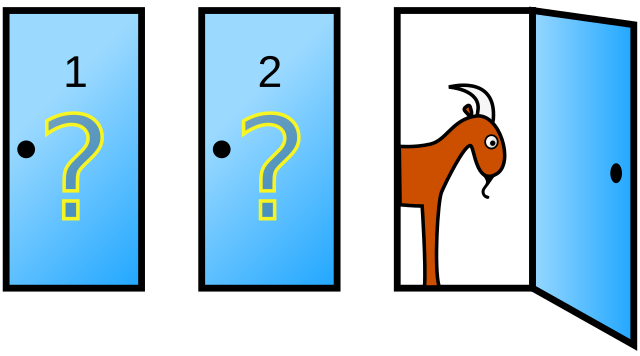

In [19]:
from PIL import Image
montey_hall_image = Image.open("montey_hall.png")
montey_hall_image

In [20]:
prompt="""
Run a simulation of the Monty Hall Problem with 1,000 trials.


Here's how this works as a reminder. In the Monty Hall Problem, you're on a game
show with three doors. Behind one is a car, and behind the others are goats. You
pick a door. The host, who knows what's behind the doors, opens a different door
to reveal a goat. Should you switch to the remaining unopened door?


The answer has always been a little difficult for me to understand when people
solve it with math - so please run a simulation with Python to show me what the
best strategy is.


Thank you!
"""
result = model.generate_content([montey_hall_image, prompt])
Markdown(result.text)

I understand. The Monty Hall problem is a classic probability puzzle that often leads to counterintuitive conclusions. Let's run a simulation in Python to see how the odds play out.


``` python
import random

def monty_hall(switch):
  """Simulates a single round of the Monty Hall problem."""
  doors = [0, 1, 2]
  car_door = random.choice(doors)
  initial_choice = random.choice(doors)

  # Host reveals a goat
  if initial_choice != car_door:
    host_reveal = random.choice([d for d in doors if d != initial_choice and d != car_door])
  else:
    host_reveal = random.choice([d for d in doors if d != initial_choice])

  # Switch or stay
  if switch:
    final_choice = [d for d in doors if d != initial_choice and d != host_reveal][0]
  else:
    final_choice = initial_choice

  return final_choice == car_door

def run_trials(trials, switch):
  """Runs a set of Monty Hall trials with the specified switch strategy."""
  wins = 0
  for _ in range(trials):
    if monty_hall(switch):
      wins += 1
  return wins / trials

# Run simulations
trials = 1000
stay_win_rate = run_trials(trials, switch=False)
switch_win_rate = run_trials(trials, switch=True)

print(f"Win rate staying: {stay_win_rate * 100:.2f}%")
print(f"Win rate switching: {switch_win_rate * 100:.2f}%")

```
```
Win rate staying: 32.60%
Win rate switching: 66.90%

```
The simulation results show that switching doors significantly increases your chances of winning the car. The win rate for staying is around 33%, while the win rate for switching is around 67%. This confirms the counterintuitive but mathematically proven result of the Monty Hall problem: switching doors doubles your chances of winning. 


## Streaming

Streaming is compatible with code execution. Just note that successive parts of the same type (`text`, `executable_code` or `execution_result`) are meant to be joined together:

In [21]:
result = model.generate_content([montey_hall_image, prompt], stream=True)
for chunk in result:
  print(chunk.candidates[0].content.parts[0])
  print('----------------------------------------')

text: "I understand"

----------------------------------------
text: ", the Monty Hall Problem can be confusing! Let\'s run a simulation to see"

----------------------------------------
text: " the results.\n\nI\'ll simulate 1,000 trials of the"

----------------------------------------
text: " game and keep track of whether switching doors wins or loses. I\'ll then compare the results of switching and not switching.\n\n"

----------------------------------------
executable_code {
  language: PYTHON
  code: "\nimport random\n\ndef play_monty_hall(switch):\n  \"\"\"Plays one round of the Monty Hall game and returns whether the player wins.\"\"\"\n  # Choose a random door for the car\n  car_door = random.randint(1, 3)\n\n  # Player picks a random door\n  player_choice = random.randint(1, 3)\n\n  # Host opens a door with a goat\n  if player_choice == car_door:\n    # Host opens a random door that\'s not the car door\n    host_reveal = random.choice([door for door in [1, 2, 3] if door != 

The result object automatically joins the parts, as you iterate over them:

In [22]:
for part in result.candidates[0].content.parts:
  print(part)
  print('----------------------------------------')

text: "I understand, the Monty Hall Problem can be confusing! Let\'s run a simulation to see the results.\n\nI\'ll simulate 1,000 trials of the game and keep track of whether switching doors wins or loses. I\'ll then compare the results of switching and not switching.\n\n"

----------------------------------------
executable_code {
  language: PYTHON
  code: "\nimport random\n\ndef play_monty_hall(switch):\n  \"\"\"Plays one round of the Monty Hall game and returns whether the player wins.\"\"\"\n  # Choose a random door for the car\n  car_door = random.randint(1, 3)\n\n  # Player picks a random door\n  player_choice = random.randint(1, 3)\n\n  # Host opens a door with a goat\n  if player_choice == car_door:\n    # Host opens a random door that\'s not the car door\n    host_reveal = random.choice([door for door in [1, 2, 3] if door != car_door])\n  else:\n    # Host opens the other door with a goat\n    host_reveal = [door for door in [1, 2, 3] if door != player_choice and door != car_

In [23]:
print(result.text)

I understand, the Monty Hall Problem can be confusing! Let's run a simulation to see the results.

I'll simulate 1,000 trials of the game and keep track of whether switching doors wins or loses. I'll then compare the results of switching and not switching.


``` python
import random

def play_monty_hall(switch):
  """Plays one round of the Monty Hall game and returns whether the player wins."""
  # Choose a random door for the car
  car_door = random.randint(1, 3)

  # Player picks a random door
  player_choice = random.randint(1, 3)

  # Host opens a door with a goat
  if player_choice == car_door:
    # Host opens a random door that's not the car door
    host_reveal = random.choice([door for door in [1, 2, 3] if door != car_door])
  else:
    # Host opens the other door with a goat
    host_reveal = [door for door in [1, 2, 3] if door != player_choice and door != car_door][0]

  # Player switches doors
  if switch:
    player_choice = [door for door in [1, 2, 3] if door != player_ch

## Next Steps
### Useful API references:

Check the [Code execution documentation](https://ai.google.dev/gemini-api/docs/code-execution) for more details about the feature and in particular, the [recommendations](https://ai.google.dev/gemini-api/docs/code-execution?lang=python#code-execution-vs-function-calling) regarding when to use it instead of [function calling](https://ai.google.dev/gemini-api/docs/function-calling).

### Continue your discovery of the Gemini API

Learn how to control how the Gemini API can call your own functions using the [function calling](../quickstarts/Function_calling.ipynb) feature, or discover how to control the model output in [JSON](../quickstarts/JSON_mode.ipynb) or using an [Enum](../quickstarts/Enum.ipynb).